In [1]:
import multiresolutionimageinterface as mir
import openslide
import numpy as np
import skimage
import matplotlib.pyplot as plt
import math
from skimage import morphology, measure,color,io, exposure
from scipy import ndimage

In [2]:
def filter_ch(rgb):
    (h, w, c) = rgb.shape
    rgb = rgb.astype(np.int)
    r_f = (rgb[:,:,0] > 47) & (rgb[:,:,0] < 130)
    g_f = (rgb[:,:,1] > 47) & (rgb[:,:,1] < 130)
    b_f = (rgb[:,:,2] > 40) & (rgb[:,:,2] < 110)
    mask = (r_f & b_f & g_f)
    mask = morphology.binary_dilation(mask, selem=morphology.disk(3))
    return ~mask

In [76]:

# slide = openslide.OpenSlide('/media/steer/data1/Images/47.tif')

slide = openslide.OpenSlide('/run/user/1000/gvfs/sftp:host=192.168.1.101/home/data/ACDC/Images/115.tif')

In [99]:
slide.level_dimensions, slide.level_downsamples

(((80522, 176548),
  (40261, 88274),
  (20130, 44137),
  (10065, 22068),
  (5032, 11034),
  (2516, 5517),
  (1258, 2758),
  (629, 1379)),
 (1.0,
  2.0,
  4.000049677098858,
  8.000189983162732,
  16.001174898629557,
  32.002349797259114,
  64.0105010312535,
  128.021002062507))

In [101]:
629 * slide.level_downsamples[-1]

80525.2102973169

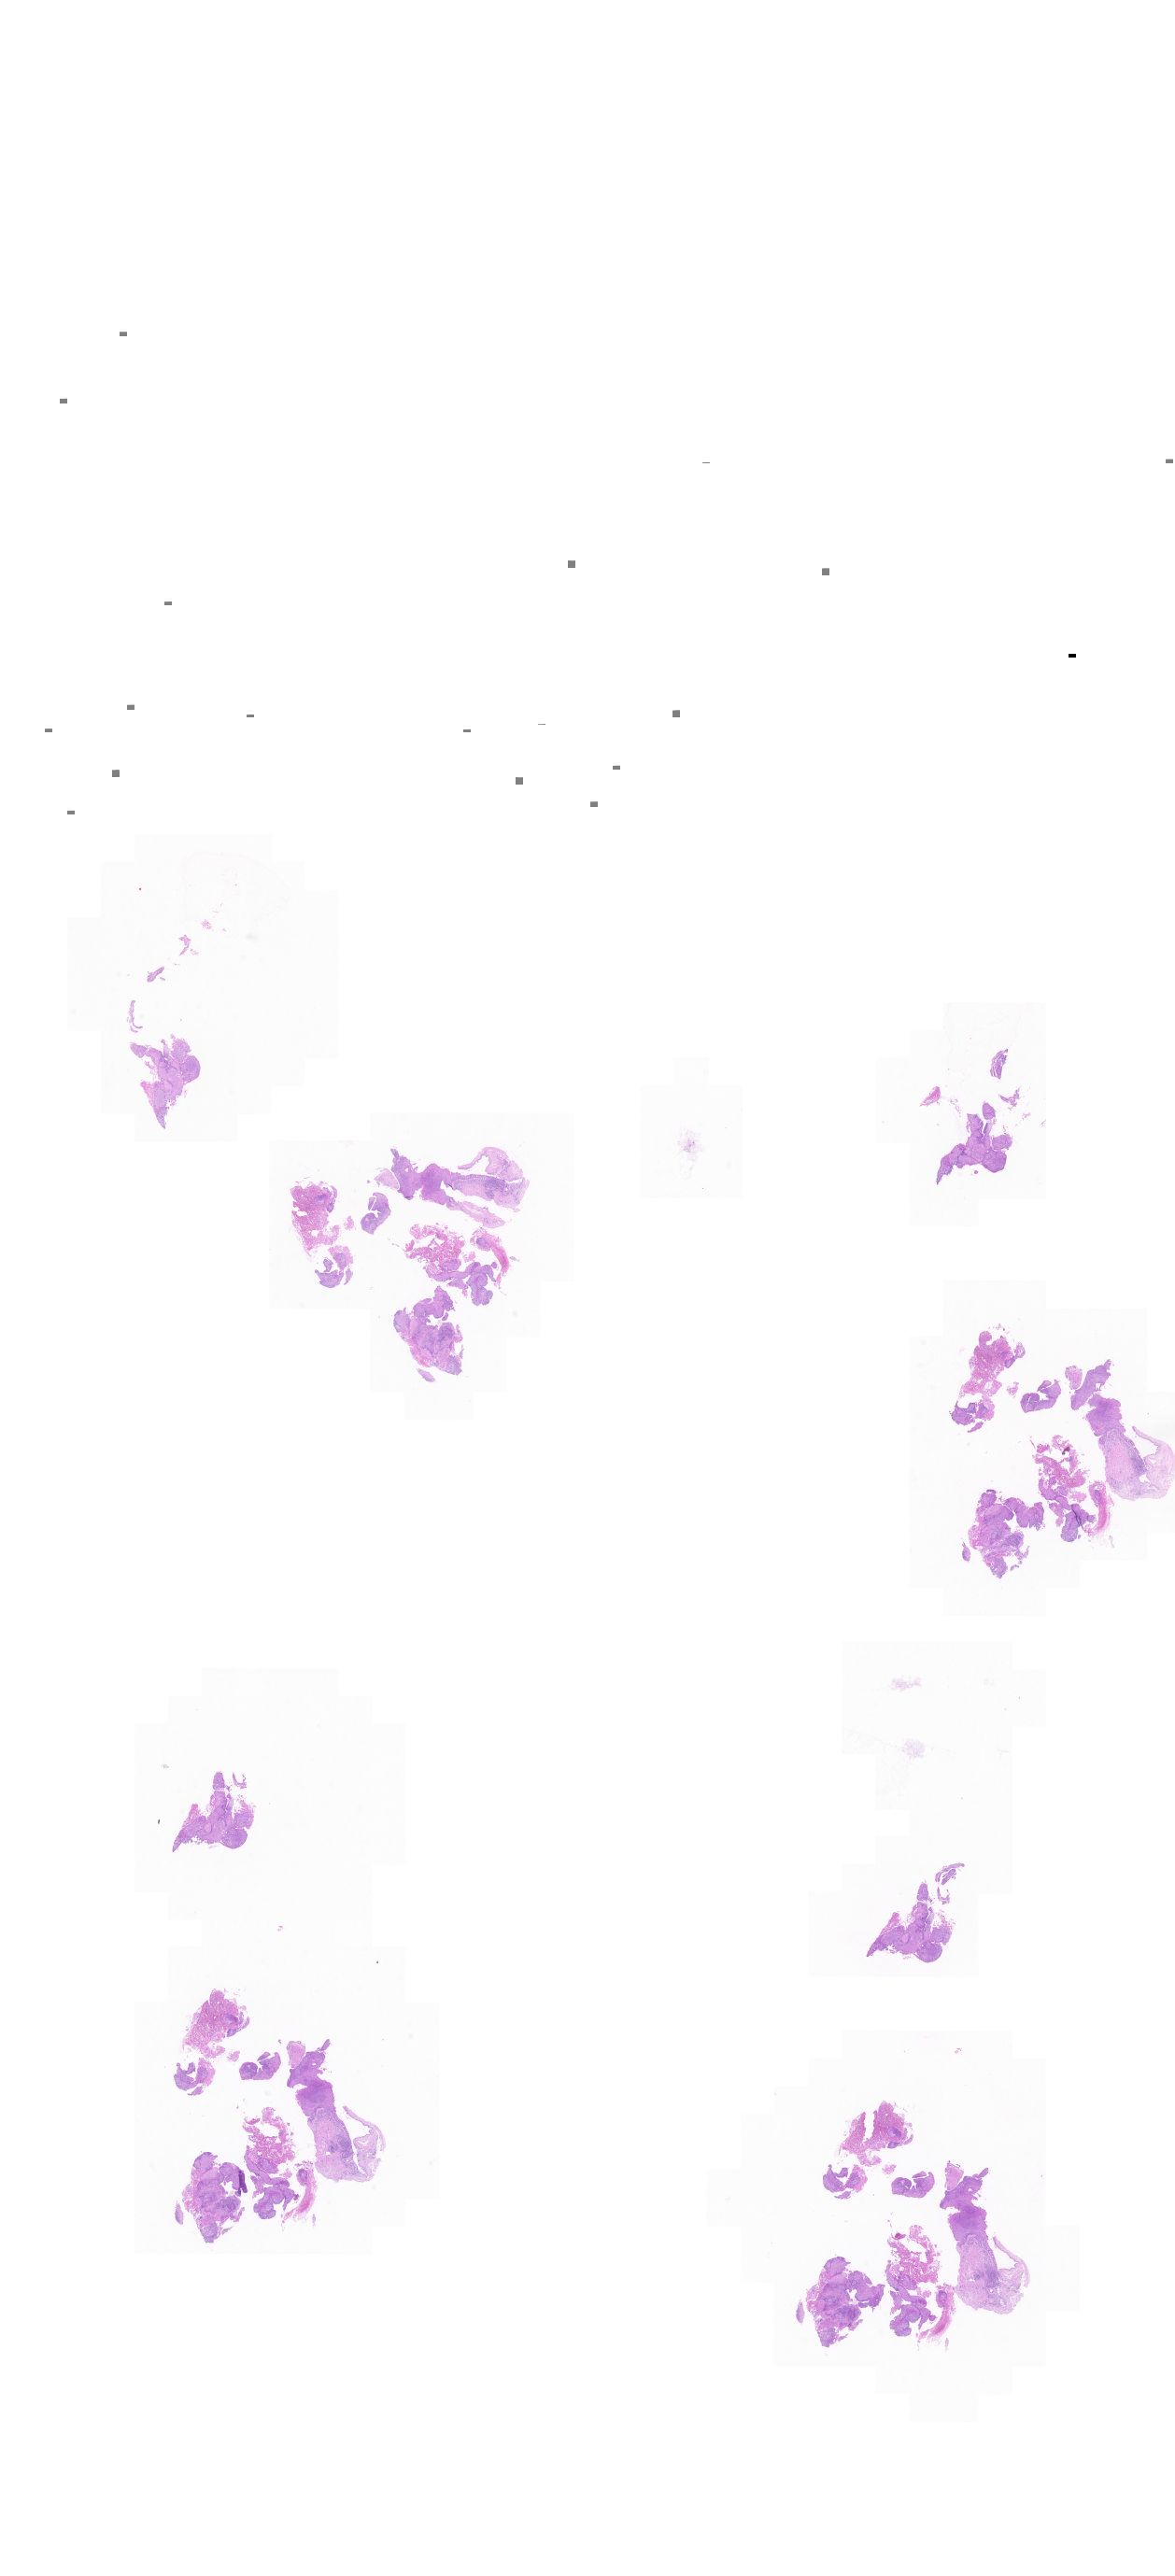

In [102]:
thumb = slide.get_thumbnail(slide.level_dimensions[6])
thumb

In [103]:
thumb_rgb = np.asarray(thumb)

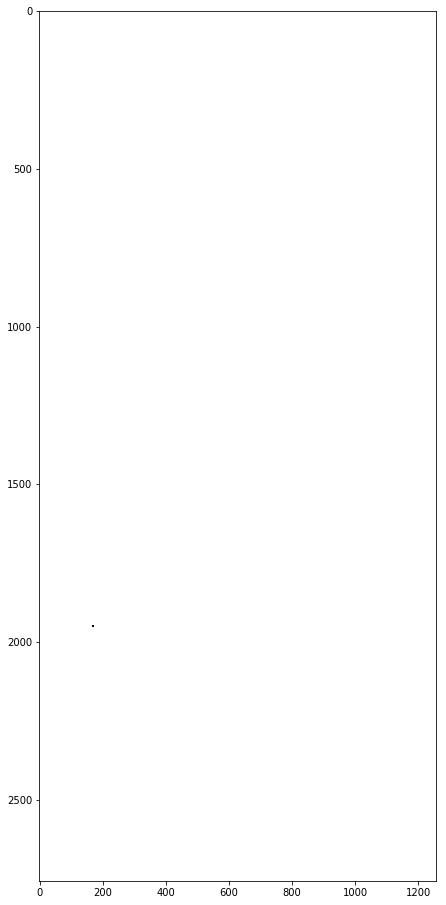

In [104]:
ret = filter_ch(thumb_rgb)
# ret = ~morphology.binary_dilation(~ret, selem=morphology.disk(3))
plt.figure(figsize=(16,16))
plt.imshow(ret, cmap = plt.cm.gray)

In [105]:
thumb_gray = skimage.color.rgb2gray(np.array(thumb))

In [106]:
import matplotlib as mpl

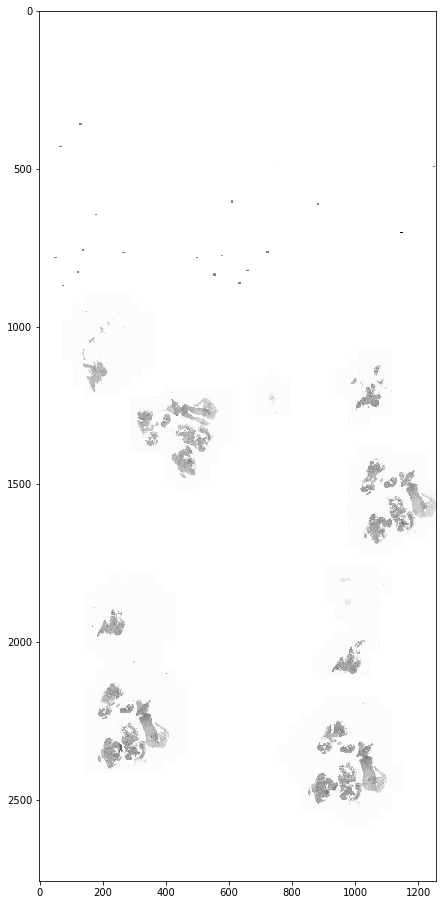

In [107]:
plt.figure(figsize=(16,16))
plt.imshow(thumb_gray, cmap=plt.cm.gray)

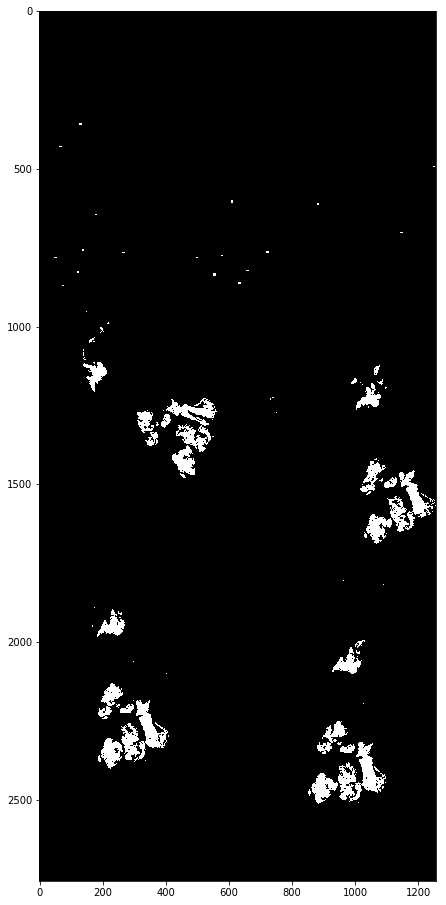

In [108]:
from skimage.filters import threshold_otsu, threshold_local
thresh = threshold_otsu(thumb_gray)
mask = thumb_gray < thresh
# mask = morphology.binary_erosion(mask, selem=morphology.rectangle(3,5))
plt.figure(figsize=(16,16))
plt.imshow(mask, cmap=plt.cm.gray)

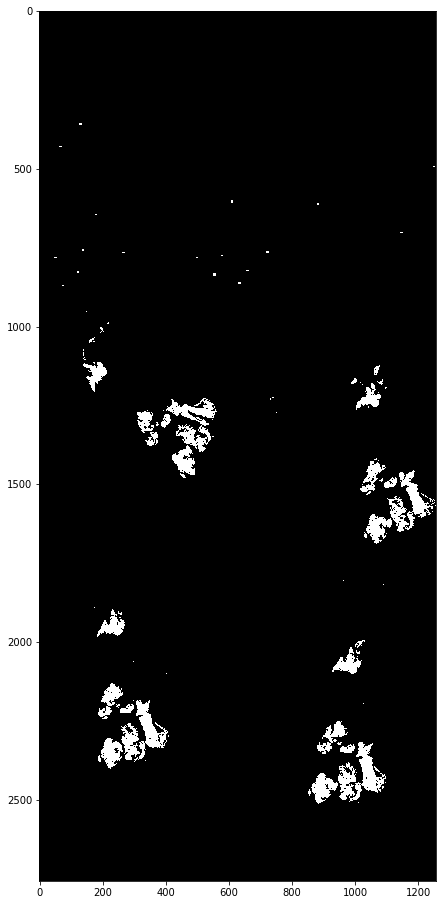

In [109]:
mask = mask&ret
plt.figure(figsize=(16,16))
plt.imshow(mask, cmap=plt.cm.gray)

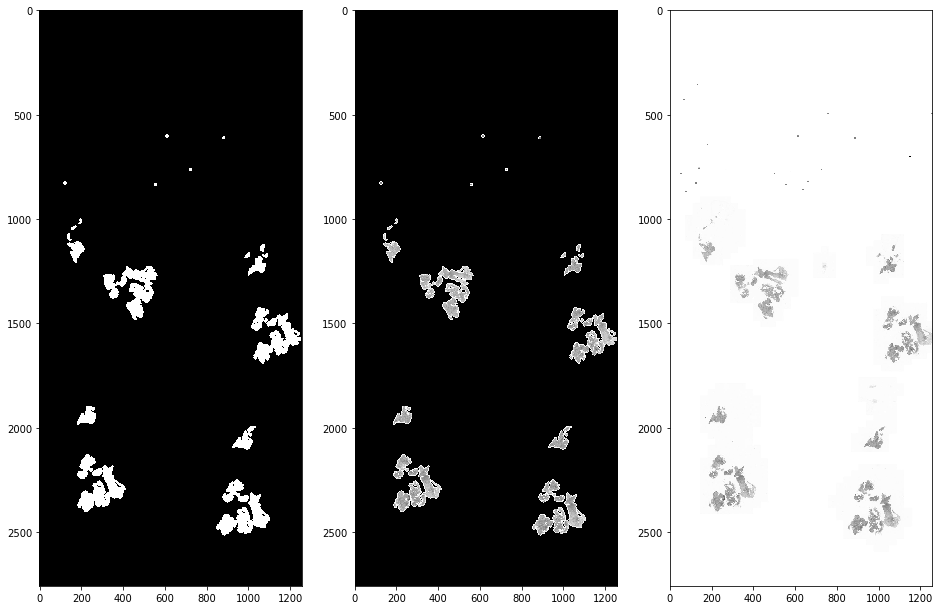

In [110]:
mask = ndimage.morphology.binary_fill_holes(mask)
mask = morphology.remove_small_objects(mask)
mask = morphology.binary_dilation(mask, morphology.disk(4))
fg, ax = plt.subplots(1,3, figsize=(16,16))
# plt.figure(figsize=(16,16))
ax[0].imshow(mask, cmap=plt.cm.gray)
ax[1].imshow(mask*thumb_gray, cmap=plt.cm.gray)
ax[2].imshow(thumb_gray, cmap=plt.cm.gray)

In [111]:
mask_c = mask

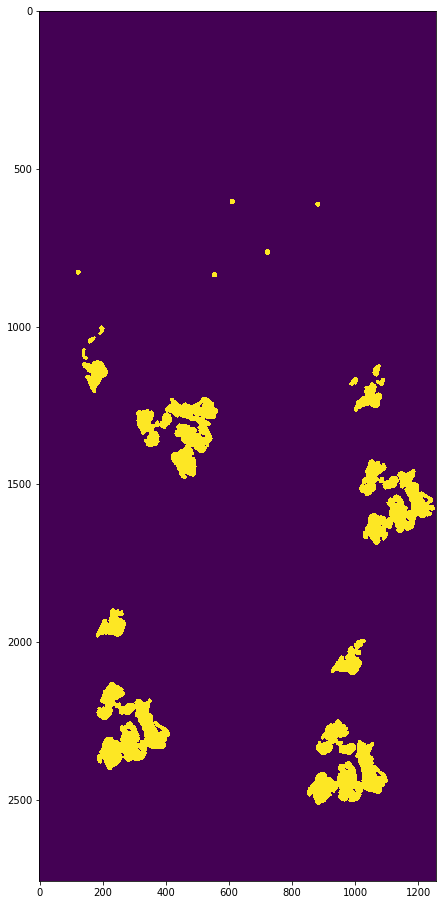

In [112]:
mask = morphology.binary_dilation(mask)
mask = morphology.binary_erosion(mask)
# convx = morphology.convex_hull_object(mask)
plt.figure(figsize=(16, 16))
plt.imshow(mask)

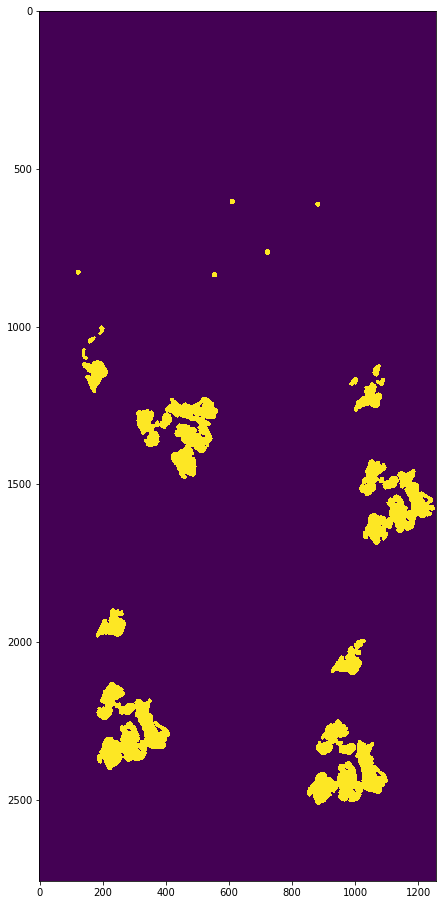

In [113]:
closed = morphology.binary_closing(mask, )
plt.figure(figsize=(16, 16))
plt.imshow(closed)

In [24]:
import matplotlib.patches as mpatches

In [89]:
thumb_gray.max(), thumb_gray.min()

(1.0, 0.0)

In [90]:
glass_mask = thumb_gray != 1

In [91]:
# label_image = measure.label(glass_mask)
label_image = measure.label(mask)

In [92]:
image_label_overlay = skimage.color.label2rgb(label_image, image=mask)

In [93]:
region = measure.regionprops(label_image)[0]

In [ ]:
region.bbox

In [ ]:
thumb_gray.shape

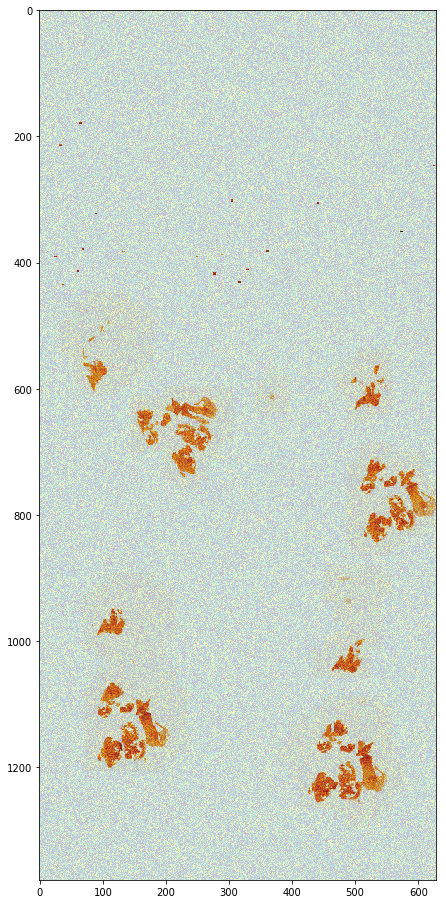

In [94]:
# np.random.rand(3,4)
g = color.gray2rgb(np.random.rand(3,4))
plt.figure(figsize=(16,16))
plt.imshow(thumb_gray, cmap=plt.cm.gist_heat)
plt.imshow(np.random.rand(1379, 629), alpha=0.3)

In [31]:
def overlap1D(xmin1, xmax1, xmin2, xmax2):
    return xmax1 >= xmin2 and xmax2 >= xmin1


def intersect(bbox1, bbox2):
    """
    判定两bbox是否相交
    """
    lr1, lc1, hr1, hc1 = bbox1
    lr2, lc2, hr2, hc2 = bbox2
    # 1 in 2 or 2 in 1
    return overlap1D(lr1, hr1, lr2, hr2) and overlap1D(lc1, hc1, lc2, hc2)

def merge_bbox(bboxes: list):
    """
    整合bbox, 将有相交的整合成更大的bbox
    :param bboxes:
    :return:
    """
    for idx in range(len(bboxes)):
        current_bbox = bboxes[idx]
        for next_idx in range(idx + 1, len(bboxes)):
            other_bbox = bboxes[next_idx]
            if intersect(current_bbox, other_bbox):
                minr = min(current_bbox[0], other_bbox[0])
                minc = min(current_bbox[1], other_bbox[1])
                maxr = max(current_bbox[2], other_bbox[2])
                maxc = max(current_bbox[3], other_bbox[3])
                bboxes.pop(idx)
                bboxes.pop(next_idx - 1)
                bboxes.append((minr, minc, maxr, maxc))
                return merge_bbox(bboxes)
    return bboxes

In [95]:
bbox = []
for each in measure.regionprops(label_image):
    bbox.append(each.bbox)
bbox = merge_bbox(bbox)

In [96]:
minr, minc, maxr, maxc = (112, 281, 181, 384)
maxr - minr, maxc - minc

(69, 103)

(552, 66, 608, 111)
(558, 526, 581, 544)
(586, 497, 638, 546)
(944, 88, 995, 140)
(993, 460, 1055, 520)
(610, 152, 740, 286)
(708, 504, 849, 629)
(1061, 89, 1205, 209)
(1121, 427, 1261, 555)


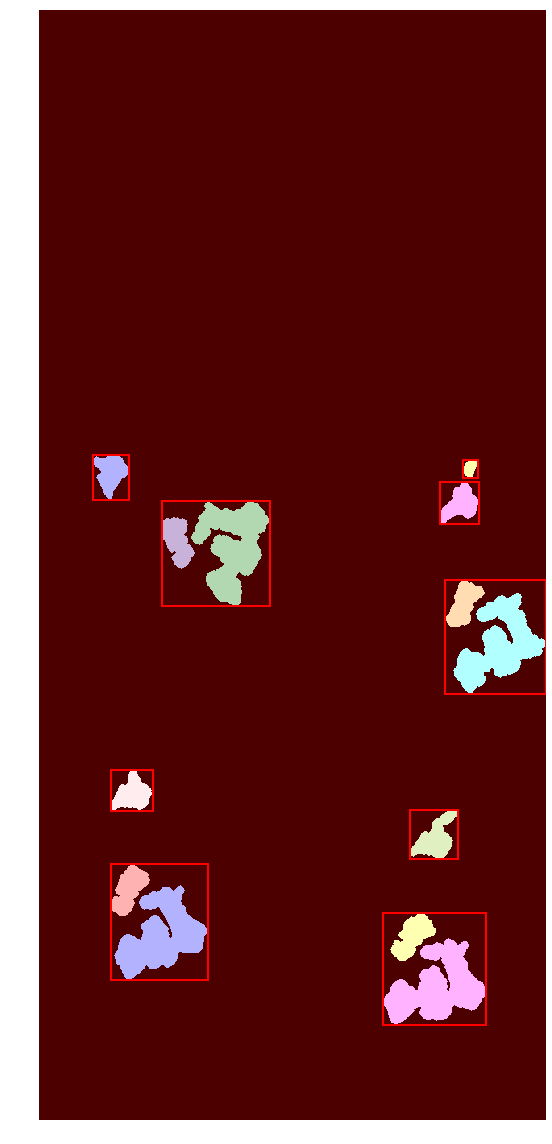

In [98]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_label_overlay)

for bb in bbox:

    minr, minc, maxr, maxc = bb
    print(bb)
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        print(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()